In [123]:
import numpy as np
import xarray as xr
import os
from matplotlib import pyplot as plt
import cartopy.crs as ccrs


In [124]:
M = 0.8 #change later
reference_fuel_consumption = 0.7296 #who knows
reference_nox = 19.1835 #IDGAF
number_of_engines = 2 
temp_sea_level = 288.15 #kelvins
pres_sea_level = 101325 #pascals
gamma = 1.4
R = 287.05


In [125]:
#merge echam, accf and contrail datasets for each month into datasets representing whole year
directory = os.fsencode("C:/Users/macie/OneDrive/Desktop/Project_A02/Project_data/DT00/AT20_optimal")
dir = "C:/Users/macie/OneDrive/Desktop/Project_A02/Project_data/DT00/AT20_optimal"
echam_files = []
accf_files = []
contrail_files = []
airtraf_files = []
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith("ECHAM5.nc"):
        echam_files.append(os.path.join(dir, filename))
    elif filename.endswith("accf_gp.nc"):
        accf_files.append(os.path.join(dir, filename))
    elif filename.endswith("contrail_gp.nc"):
        contrail_files.append(os.path.join(dir, filename))
    elif filename.endswith("airtraf_gp.nc"):
        airtraf_files.append(os.path.join(dir, filename))
    else:
        continue
if echam_files:
    merged_echam = xr.open_mfdataset(echam_files, combine='nested', concat_dim='time')
if accf_files:
    merged_accf = xr.open_mfdataset(accf_files, combine='nested', concat_dim='time')
if contrail_files:
    merged_contrail = xr.open_mfdataset(contrail_files, combine='nested', concat_dim='time')
if airtraf_files:
    merged_airtraf = xr.open_mfdataset(airtraf_files, combine='nested', concat_dim='time')
 

In [126]:
#taking 2018 as the only time period
merged_echam = merged_echam.sel(time = slice("2018-01-01", "2018-12-31"))
merged_accf = merged_accf.sel(time = slice("2018-01-01", "2018-12-31"))
merged_contrail = merged_contrail.sel(time = slice("2018-01-01", "2018-12-31"))
merged_airtraf = merged_airtraf.sel(time = slice("2018-01-01", "2018-12-31"))
#calculates mean for each month and creates new dataarrays
merged_echam_compressed = []
merged_accf_compressed = []
merged_contrail_compressed = []
merged_airtraf_compressed = []
for i in range(1,13):
    merged_echam_compressed.append(merged_echam.sel(time=merged_echam['time.month'] == i).mean(dim='time'))
    merged_accf_compressed.append(merged_accf.sel(time=merged_accf['time.month'] == i).mean(dim='time'))
    merged_contrail_compressed.append(merged_contrail.sel(time=merged_contrail['time.month'] == i).mean(dim='time'))
    merged_airtraf_compressed.append(merged_airtraf.sel(time=merged_airtraf['time.month'] == i).mean(dim='time'))
merged_echam_compressed = xr.concat(merged_echam_compressed, dim='time')
merged_accf_compressed = xr.concat(merged_accf_compressed, dim='time')
merged_contrail_compressed = xr.concat(merged_contrail_compressed, dim='time')
merged_airtraf_compressed = xr.concat(merged_airtraf_compressed, dim='time')
#months go from '1-12', the index starts at '0' as for all arrays

In [127]:
#aircrafts velocity based on its mach number
velocity = M*np.sqrt(gamma*R*merged_echam_compressed['tm1'])
#correction coefficients for fuel consumption
delta = merged_echam_compressed['tm1']*(1+0.2*M**2)**3.5 / temp_sea_level
theta = merged_echam_compressed['press']*(1+0.2*M**2)**3.5 / pres_sea_level
#actual fuel consumption per engine
f_a_i = reference_fuel_consumption*delta*np.sqrt(theta)
#total fuel consumption
f_cr = f_a_i*number_of_engines
#humidity correction coefficient
H_c = np.exp(-19*(merged_echam_compressed['qm1']-0.00634))
#nox emission corrected for cruise conditions
EINO_x = reference_nox*delta**0.4*theta**0.3*H_c
#F-ATR20 for each emission in kelvins per kilometer
co2_atr20_perkm = merged_accf_compressed['atr20_co2']/velocity*f_cr
h2o_atr20_perkm = merged_accf_compressed['atr20_h2o']/velocity*f_cr
o3_atr20_perkm = merged_accf_compressed['atr20_o3']/velocity*f_cr*EINO_x*10**(-3)
ch4_atr20_perkm = merged_accf_compressed['atr20_ch4']/velocity*f_cr*EINO_x*10**(-3)
contr_atr20_perkm = merged_accf_compressed['atr20_contrail']*merged_contrail_compressed['potcov']


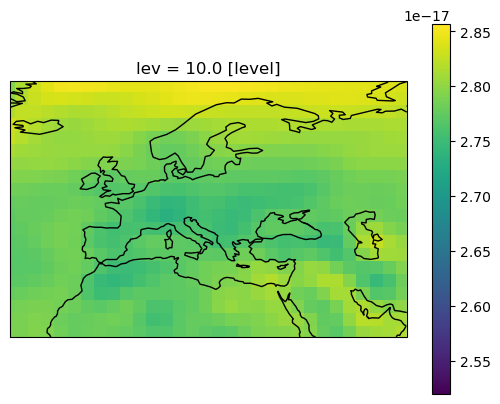

In [128]:
var = co2_atr20_perkm.isel(time=5).sel(lev=10.0)
#var = var.where(var > 1e-20)
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.stock_img()
ax.coastlines()

extent = [-25, 60, 20, 70]
ax.set_extent(extent)
p = var.plot(transform=ccrs.PlateCarree())#,vmin=6.9e-15, vmax=7.2e-15)

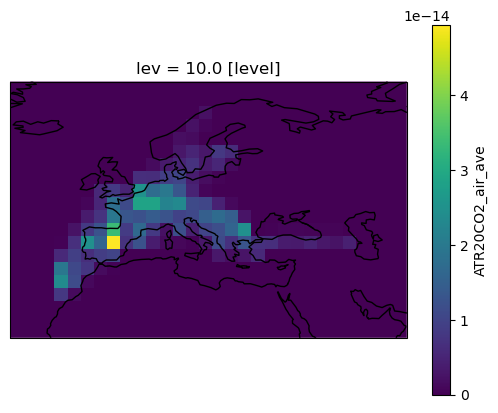

In [129]:
#lev range 8-14
var = merged_airtraf_compressed['ATR20CO2_air_ave'].isel(time=5).sel(lev=10.0)
#var = var.where(var > 1e-20)
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.stock_img()
ax.coastlines()

extent = [-25, 60, 20, 70]
ax.set_extent(extent)
p = var.plot(transform=ccrs.PlateCarree())#,vmin=6.9e-15, vmax=7.2e-15)